In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

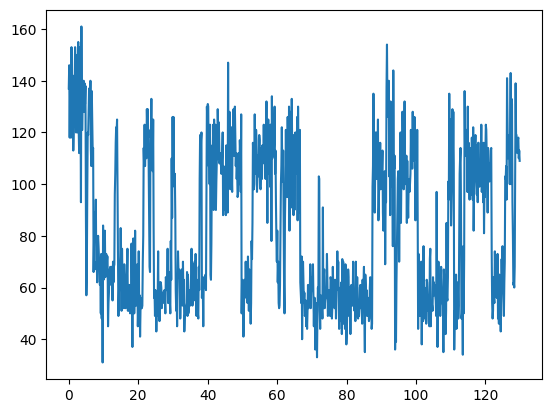

In [2]:
table = pd.read_table('Dynamic Equilibrium of Unimolecular Reaction Data.txt',header=None)
table.columns=["Time (s)", "Fluorescence Intensity"]
table
plt.plot(table['Time (s)'],table['Fluorescence Intensity'])

In [3]:
# Step 1: Load only the fluorescence intensity data from the second column
data = np.loadtxt('Dynamic Equilibrium of Unimolecular Reaction Data.txt', usecols=1)  # Load the second column (intensity)
data = data.flatten()  # Ensure it is a 1D array

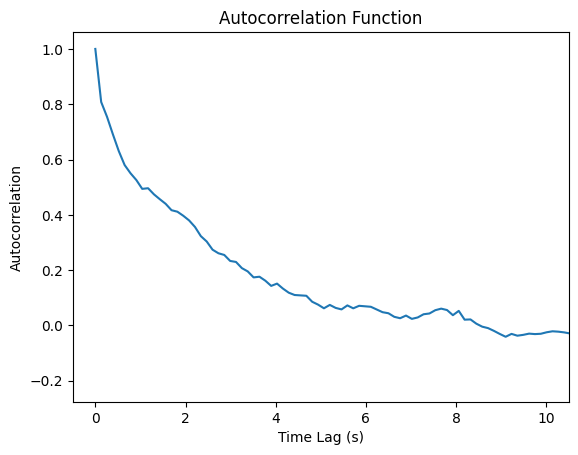

Decay constant: 2.2190119153924623


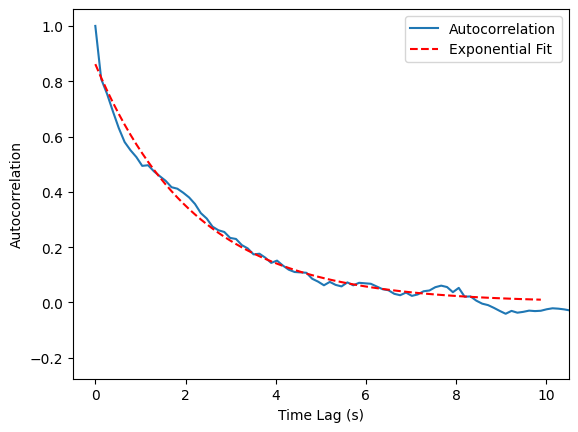

In [4]:

# Step 2: Calculate the autocorrelation function
def autocorrelation(signal):
    signal = signal - np.mean(signal)
    result = np.correlate(signal, signal, mode='full')
    result = result[result.size // 2:]  # Take the second half
    return result / result[0]  # Normalize

autocorr = autocorrelation(data)

# Step 3: Plot the autocorrelation function
time_lags = np.arange(len(autocorr)) * 0.13  # 130 ms per measurement
plt.plot(time_lags, autocorr)
plt.xlabel("Time Lag (s)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function")
plt.xlim((-0.5,10.5))
plt.show()

# Step 4: Fit an exponential decay to find the decay constant
def exponential_decay(t, a, tau):
    return a * np.exp(-t / tau)

# Fit only the first 10 seconds
fit_time = time_lags[time_lags <= 10]
fit_autocorr = autocorr[:len(fit_time)]
popt, _ = curve_fit(exponential_decay, fit_time, fit_autocorr)

# Extract the decay constant
decay_constant = popt[1]
print("Decay constant:", decay_constant)

# Plot with fitted curve
plt.plot(time_lags, autocorr, label="Autocorrelation")
plt.plot(fit_time, exponential_decay(fit_time, *popt), 'r--', label="Exponential Fit")
plt.xlabel("Time Lag (s)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.xlim((-0.5,10.5))
plt.show()


$$
\text{Decay constant}= 2.22
$$
The decay constant quantifies how quickly the correlation between the signal at different time points diminishes and relates to the rates of these transitions. A shorter decay time may imply that the molecule quickly switches between states, leading to rapid changes in fluorescence intensity and vice versa.

Decay constant can also indicate the characteristic time $\tau$, during which, the autocorrelation drops to $\frac{1}{e}=e^{-1}$ of its initial value (1).

Therefore, we can have the following argument:
$$
t_{\text{on}}+t_{\text{off}}=\tau=0.22\ \text{s}
$$

In [5]:

fluorescence_data = table['Fluorescence Intensity']

threshold = 80  # Determine based on analysis

# Classify states
states = ['on' if intensity > threshold else 'off' for intensity in fluorescence_data]

# Calculate total times
time_per_measurement = 0.130  # seconds
total_time_on = 0
total_time_off = 0
current_state = states[0]
state_duration = 0

for state in states:
    if state == current_state:
        state_duration += time_per_measurement
    else:
        if current_state == 'on':
            total_time_on += state_duration
        else:
            total_time_off += state_duration
        current_state = state
        state_duration = time_per_measurement

# Don't forget to add the last state duration
if current_state == 'on':
    total_time_on += state_duration
else:
    total_time_off += state_duration

In [6]:

# Calculate the rate constants
t_total = total_time_on + total_time_off
p1 = total_time_on / t_total
p_neg1 = total_time_off / t_total

# Calculate the free energy difference
R = 8.314  # J/(mol K)
T = 298  # K
delta_G = -R * T * np.log(p1 / p_neg1)

print(f"P(on): {p1:.4f}, P(off): {p_neg1:.4f}, ΔG: {delta_G:.4f} J/mol")


P(on): 0.4770, P(off): 0.5230, ΔG: 228.0976 J/mol


$$
P(\text{on}) = \frac{t_{\text{on}}}{t_{\text{on}} + t_{\text{off}}}, P(\text{on}) = \frac{t_{\text{off}}}{t_{\text{on}} + t_{\text{off}}}
$$

$$
\Delta G = -RT \ln\left(\frac{P(\text{on})}{P(\text{off})}\right)
$$

where:  
$$
R \approx 8.314 \, \text{J/(mol K)}, \quad T \approx 298 \, \text{K}
$$


$$
P(\text{on}) = 0.4770, \quad P(\text{off}) = 0.5230, \quad \Delta G = 228.0976 \, \text{J/mol}
$$


In [7]:
ton = decay_constant*p1
toff = decay_constant*p_neg1
print(f'{ton=}; {toff=}')
k_off = 1/toff
k_on = 1/ton
print(f'{k_on=}; {k_off=}')

ton=1.0584686836422044; toff=1.1605432317502578
k_on=0.9447610642187232; k_off=0.861665444803692


$$
\tilde t_{\text{on}}=\tau \times P(\text{on})=1.05\ \text{s}
$$
$$
\tilde t_{\text{off}}=\tau \times P(\text{off})=1.16\ \text{s}
$$
$$
k_{1}=\frac{1}{\tilde t_{\text{on}}}=0.94
$$
$$
k_{-1}=\frac{1}{\tilde t_{\text{of}}}=0.86
$$

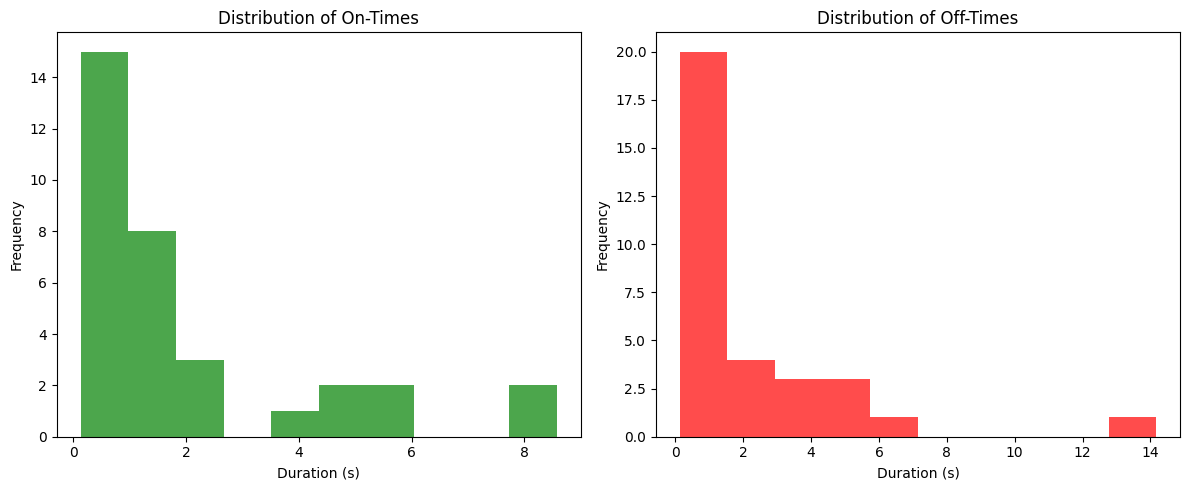

average_on_time=1.8790909090909085; average_off_time=2.1246875000000003
Estimated k1: 0.5322, Estimated k-1: 0.4707


In [8]:

# Classify states and calculate durations
states = ['on' if intensity > threshold else 'off' for intensity in fluorescence_data]
time_per_measurement = 0.130  # in seconds

# Collect on-times and off-times
on_times = []
off_times = []
current_state = states[0]
state_duration = 0

for state in states:
    if state == current_state:
        state_duration += time_per_measurement
    else:
        if current_state == 'on':
            on_times.append(state_duration)
        else:
            off_times.append(state_duration)
        current_state = state
        state_duration = time_per_measurement

# Add the last state duration
if current_state == 'on':
    on_times.append(state_duration)
else:
    off_times.append(state_duration)

# Plot distributions
plt.figure(figsize=(12, 5))

# Histogram for on-times
plt.subplot(1, 2, 1)
plt.hist(on_times, bins=10, color='green', alpha=0.7)
plt.title('Distribution of On-Times')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

# Histogram for off-times
plt.subplot(1, 2, 2)
plt.hist(off_times, bins=10, color='red', alpha=0.7)
plt.title('Distribution of Off-Times')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate average times
average_on_time = np.mean(on_times)
average_off_time = np.mean(off_times)
print(f'{average_on_time=}; {average_off_time=}')

# Calculate rate constants
k1 = 1 / average_on_time if average_on_time > 0 else 0
k_neg1 = 1 / average_off_time if average_off_time > 0 else 0

print(f"Estimated k1: {k1:.4f}, Estimated k-1: {k_neg1:.4f}")


### Estimation of Rate Constants

- The rate constants can be estimated as follows:
  - For the rate constant of the "on" state:
    $$ k_1 = \frac{1}{\langle t_{on} \rangle} $$

  - For the rate constant of the "off" state:
    $$ k_{-1} = \frac{1}{\langle t_{off} \rangle} $$


### Estimated Rate Constants

- **Estimated Values**:
  - $k_{1} = 0.53$
  - $k_{-1} = 0.47$

### Comparison with Previous Results

- **Previous Values**:
  - $k_{1} = 0.94$
  - $k_{-1} = 0.86$

### Analysis

1. **$k_{1}$**:
   - **Previous**: $0.94$
   - **Current**: $0.53$
   - The new estimate of $k_{1}$ is significantly lower, suggesting that the molecule spends more time in the "on" state than previously estimated, indicating a lower rate of transition to the "off" state.

2. **$k_{-1}$**:
   - **Previous**: $0.86$
   - **Current**: $0.47$
   - The new estimate of $k_{-1}$ is also lower, suggesting a slightly decreased rate of transition from the "off" to the "on" state.

### Possible Reasons for Discrepancy
The method of selecting the threshold to distinguish between "on" and "off" states can greatly affect the calculated durations. Besides the estimation is a rather rough manipulation because it presume the sudden change of state which neglecting the concentration dependency of rate of reaction. The estimation takes a statistically averaged number to represent the curved dynamic process, which must lead to the slight discrepancy.

Besides, $\tau$ as the characteristic time fits only for exponential curve. However, the results of the experiment may not be interpreted as a exponential curve.
  

